In [3]:
from math import cos, sin
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
% matplotlib notebook

UsageError: Line magic function `%` not found.


# Given:
$$ \omega_{OA} = const = 1 rad/s\\
OA = OP = 25\\
AB = 80 \\
AC = 20$$

# The task: simulate this mechanism.

# Solution:
To simulate the mechanism we have to find the formulas for $\phi(t)$,  $x_a(t)$, $y_a(t)$, $x_b(t)$, $y_b(t)$, $x_c(t)$, $y_c(t)$.

Also, since the simulation will be discrete, make t discrete it is easy to make with the function
t = np.arange(-5, 5, dt)

All initial conditions ($x_a_0$, $AC$ and etc. are determined in the init_mechanism() function.
Calculations of all positions for point O, A, B and C are made in the simulate_mechanism() function below.


### Function for $\phi(t)$
$\phi(t) = \omega * t + \phi_0$, since $\phi_0$ is not defined in the task, in mine simulation, I prefer to make $\phi_0 = 0$

### Coordinates of points
The point has circular trajectory around point O, so the most easy way to deal with coordinate basis is to make O center of the basis and $\vec{i}$ and $\vec{j}$ parallel and perpendicular to the crank's trajectory respectively.
#### Point A
$$A_x = OA*cos(\phi)\\
A_y = OA*sin(\phi)$$
#### Point B
To find point B coordinate lets use cosine method:
Look at the triangle AOB:
$AB^2 = OA^2 + OB^2 - 2OA * OB\cos(\phi)$
Quadratic equation for OB:\
$OB = \frac{2*OA*cos(\phi * t) + \sqrt{{OA*cos(\phi * t)}^{2} - OA^{2} + AB^2}}{2}$
$$B_x = OB\\
B_y = 0$$
#### Point C
To find point C coordinate, use the property of the vectors $\vec{AB} || \vec{AC}$, $\vec{AC} = \frac{AC}{AB}*\vec{AB}$
$$C_x = A_x + \vec{AC_x}\\
C_y = A_y + \vec{AC_y}$$
### Velocities
To find velocities, use a np.gradient(all_point_coordinates, dt) function, it returns a vector of change, not so mathematical method, but whatever, there is more understanding than in geogebra's Derivative function (зочем нам 25 степень уничижительно малого коэфициента, если оно не считается!? Тьфу на геогебру)

## Accelerations
To find accelerations, use the same np.gradient(all_point_velocities, dt) function
After that I wanted to find normal and tangent parts, but there is a problem with directions. It can be easily solved with using a formula:
$$\vec{a^\tau} = \frac{|\vec{a}\times\vec{v}|}{|\vec{V}|}*\vec{\tau}$$
Vector $\vec{\tau}$ can be found as $\frac{\vec{V}}{|V|}$ since numpy is not saint and moreover is not mine simpy (sympy). So, the additional calculations were needed.


In [4]:
dt = 0.016


## initialize all predefined parameters of the mechanism and set initial coordinates of points A, B, C
def init_mechanism():
    OA = 25
    AB = 80
    AC = 20
    omega = 1
    t = np.arange(-5, 5, dt)
    phi_0 = 0
    phi = phi_0 + omega * t
    point_O = np.array([0, 0])

    coordinate_Ax_0 = 0.0
    coordinate_Ay_0 = 25.0

    point_A = np.array([coordinate_Ax_0, coordinate_Ay_0])

    coordinate_Bx = (OA * cos(phi_0) - np.sqrt(coordinate_Ax_0 ** 2 - OA ** 2 + AB ** 2))
    coordinate_By = 0
    point_B = np.array([coordinate_Bx, coordinate_By])

    vector_ab = point_B - point_A
    point_C = np.array([point_A[0] + vector_ab[0] * AC / AB, point_A[1] + vector_ab[1] * AC / AB])
    return OA, AB, AC, point_A, point_B, point_C, point_O, t, phi


def simulate_mechanism(points_A, points_B, points_C, t, phi, point_O):
    ## there u can find all kinematics of the mechanism
    for i in range(phi.size):
        # A has a circular trajectory around basis centre
        coordinate_Ax = OA * cos(phi[i])
        coordinate_Ay = OA * sin(phi[i])

        point_A = np.array([coordinate_Ax, coordinate_Ay])
        points_A = np.append(points_A, [[coordinate_Ax, coordinate_Ay]], axis=0)

        # calculate point B coordinates based on the basis with rotated axis such that B_y = 0, using cosine method
        coordinate_Bx = (OA * cos(phi[i]) - np.sqrt(coordinate_Ax ** 2 - OA ** 2 + AB ** 2))
        coordinate_By = 0

        point_B = np.array([coordinate_Bx, coordinate_By])
        points_B = np.append(points_B, [[coordinate_Bx, coordinate_By]], axis=0)

        #find  point C by vector method
        vector_ab = point_B - point_A
        points_C = np.append(points_C, [[point_A[0] + vector_ab[0] * AC / AB, point_A[1] + vector_ab[1] * AC / AB]],
                             axis=0)
    return points_A, points_B, points_C


OA, AB, AC, point_A_0, point_B_0, point_C_0, point_O, t, phi = init_mechanism()

points_A = np.array([point_A_0])
points_B = np.array([point_B_0])
points_C = np.array([point_C_0])
points_A, points_B, points_C = simulate_mechanism(points_A, points_B, points_C, t, phi, point_O)
points_O = np.array([point_O for i in t])

In [5]:
def find_velocity():
    velocities_A = np.gradient(points_A, dt, axis=0)
    velocities_B = np.gradient(points_B, dt, axis=0)
    velocities_C = np.gradient(points_C, dt, axis=0)
    return velocities_A, velocities_B, velocities_C


def find_accelerations():
    accelerations_A = np.gradient(vels_A, dt, axis=0)
    accelerations_B = np.gradient(vels_B, dt, axis=0)
    accelerations_C = np.gradient(vels_C, dt, axis=0)
    return accelerations_A, accelerations_B, accelerations_C


def normalize_acc(acc, vels):
    """ Converts the acceleration into normal and tangent accelerations, based on the velocity direction"""
    # just iterator
    i = 0
    # tangent vector
    tau = np.empty(shape=vels.shape)
    # array of tangent accelerations
    tang_a = np.empty(shape=vels.shape)
    for v in vels:
        tau[i] = v / np.linalg.norm(v)
        dot = np.dot(acc[i], v)
        norm = np.linalg.norm(v)
        new_a_t = dot / norm
        tang_a[i] = new_a_t * tau[i]
        i = i + 1
    # the easiest way to find normal acceleration
    normal_a = acc - tang_a
    return normal_a, tang_a


vels_A, vels_B, vels_C = find_velocity()
acc_A, acc_B, acc_C = find_accelerations()
n_acc_a, t_acc_a = normalize_acc(acc_A, vels_A)
n_acc_b, t_acc_b = normalize_acc(acc_B, vels_B)
n_acc_c, t_acc_c = normalize_acc(acc_C, vels_C)

print(
    "All calculations are done, you are brilliant! One next step and all is over, u can get some rest, there is no need to hurry")

All calculations are done, you are brilliant! One next step and all is over, u can get some rest, there is no need to hurry


Animating 625 frames


/home/asiia/Documents/TMHW1/venv/lib/python3.10/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Please, check second_task.mp4 file


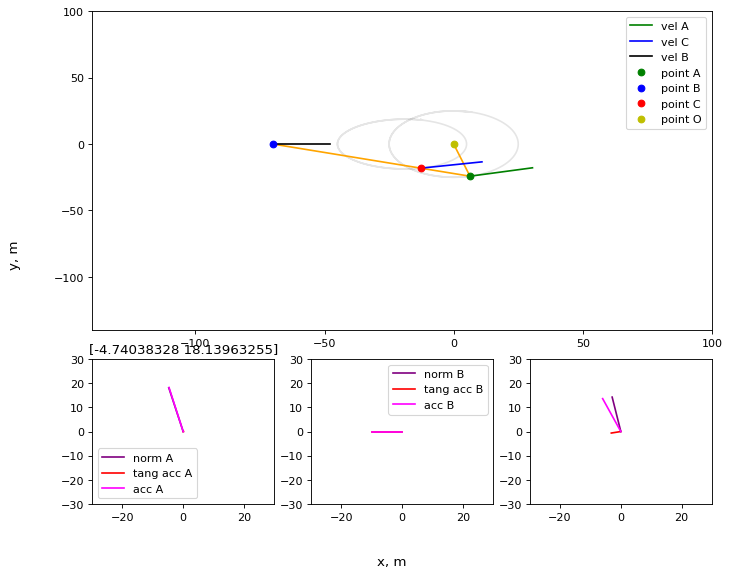

In [6]:
def draw_point(point, point_data, frame):
    """ using matplotlib sets a point data to point note in the format np.array[,] """

    point.set_data(point_data[frame][0], point_data[frame][1])


def draw_line(line, point_start, point_end, frame):
    """ using matplotlib sets point coordinates data to line, to set data use format np.array[,] """

    line.set_data([point_end[frame][0], point_start[frame][0]],
                  [point_end[frame][1], point_start[frame][1]])


def draw_vector(vector, vector_data, start_point_data, frame):
    """ using matplotlib sets vector coordinated and add it to a vector's start point to draw it in the right place, to set data use the format np.array[,] """

    vector.set_data([vector_data[frame][0] + start_point_data[frame][0], start_point_data[frame][0]],
                    [vector_data[frame][1] + start_point_data[frame][1], start_point_data[frame][1]])


def init():
    ## initialise all lines, vectors and all drawing stuff, if u want to see them
    point_o.set_data([point_O[0]], [point_O[1]])
    return traj_A, traj_C, point_a, point_b, point_c, point_o, ab_ln, ao_ln, av_ln, cv_ln, bv_ln,\
           ana_ln, bna_ln, cna_ln, ata_ln, bta_ln, cta_ln, aa_ln, ba_ln, ca_ln


def update(frame):
    # coordinates of the point
    draw_point(point_a, points_A, frame=frame)
    draw_point(point_b, points_B, frame=frame)
    draw_point(point_c, points_C, frame=frame)
    draw_line(ab_ln, points_A, points_B, frame=frame)
    draw_line(ao_ln, points_A, points_O, frame=frame)
    draw_vector(av_ln, vels_A, points_A, frame)
    draw_vector(bv_ln, vels_B, points_B, frame)
    draw_vector(cv_ln, vels_C, points_C, frame)

    # here I use point_0, since it is easier to check magnitude,
    # if vectors are drawn from (0, 0)
    draw_vector(aa_ln, acc_A, points_O, frame)
    draw_vector(ba_ln, acc_B, points_O, frame)
    draw_vector(ca_ln, acc_C, points_O, frame)
    ax2.set_title(n_acc_a[frame])
    draw_vector(ana_ln, n_acc_a, points_O, frame)
    draw_vector(bna_ln, n_acc_b, points_O, frame)
    draw_vector(cna_ln, n_acc_c, points_O, frame)
    draw_vector(ata_ln, t_acc_a, points_O, frame)
    draw_vector(bta_ln, t_acc_b, points_O, frame)
    draw_vector(cta_ln, t_acc_c, points_O, frame)

    return point_a, point_b, point_c, point_o, ab_ln, ao_ln,\
           av_ln, cv_ln, bv_ln, ana_ln, bna_ln, cna_ln,\
           ata_ln, bta_ln, cta_ln, aa_ln, ba_ln, ca_ln


## set parameters to your plot
fig = plt.figure(figsize=(10, 8), dpi=80)
# create subplots, if u want to split data into different plots
# plot for trajectories and velocities
ax1 = fig.add_subplot(3, 3, (1, 6))

# plots for accelerations A, B, C
ax2 = fig.add_subplot(3, 3, 7)
ax3 = fig.add_subplot(3, 3, 8)
ax4 = fig.add_subplot(3, 3, 9)
ax1.set_xlim(-140, 100)
ax1.set_ylim(-140, 100)
ax2.set_xlim(-30, 30)
ax2.set_ylim(-30, 30)
ax3.set_xlim(-30, 30)
ax3.set_ylim(-30, 30)
ax4.set_xlim(-30, 30)
ax4.set_ylim(-30, 30)

xdata, ydata = [], []


# plot trajectories of C and A points, B is not so interesting one, but if u want...
# traj_B = ax1.plot(points_B[:, 0], points_B[:, 1], color=(0.0, 0.0, 0.0, 0.1))

traj_A = ax1.plot(points_A[:, 0], points_A[:, 1], color=(0.0, 0.0, 0.0, 0.1))
traj_C = ax1.plot(points_C[:, 0], points_C[:, 1], color=(0.0, 0.0, 0.0, 0.1))

ab_ln, = ax1.plot([], [], 'orange')
ao_ln, = ax1.plot([], [], 'orange')

av_ln, = ax1.plot([], [], 'green', label="vel A")
cv_ln, = ax1.plot([], [], 'blue', label="vel C")
bv_ln, = ax1.plot([], [], 'black', label="vel B")

point_a, = ax1.plot([], [], 'go', label="point A")
point_b, = ax1.plot([], [], 'bo', label="point B")
point_c, = ax1.plot([], [], 'ro', label="point C")
point_o, = ax1.plot([], [], 'yo', label="point O")

ana_ln, = ax2.plot([], [], 'purple', label="norm A")
ata_ln, = ax2.plot([], [], 'red', label="tang acc A")
aa_ln, = ax2.plot([], [], 'magenta', label="acc A")

bna_ln, = ax3.plot([], [], 'purple', label="norm B")
bta_ln, = ax3.plot([], [], 'red', label="tang acc B")
ba_ln, = ax3.plot([], [], 'magenta', label="acc B")

cta_ln, = ax4.plot([], [], 'red', label="tang acc C")
cna_ln, = ax4.plot([], [], 'purple', label="norm C")
ca_ln, = ax4.plot([], [], 'magenta', label="acc C")


ax1.legend()
ax2.legend()
ax3.legend()
fig.bbox_to_anchor = (0.65, 1.25)
fig.supxlabel("x, m")
fig.supylabel("y, m")
print(f'Animating {t.size} frames')
ani = FuncAnimation(fig, update, frames=np.arange(0, t.size, 1),
# ani = FuncAnimation(fig, update, frames=np.arange(0, 10, 1),
                    init_func=init, interval=16, blit=False)

# init()
# update(0)

# ani.save("second_task.gif")
ani.save("second_task.mp4")

print("Please, check second_task.mp4 file")
# plt.show()